# Baseline Models for Wind Power Prediction

This notebook implements and evaluates baseline models:
- Persistence model
- Linear Regression
- Random Forest
- LSTM

These serve as benchmarks for comparison with the physics-aware transformer.


In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import importlib

project_root = Path().resolve().parent

# Ensure results directories exist
(project_root / 'results' / 'figures').mkdir(parents=True, exist_ok=True)
(project_root / 'results' / 'metrics').mkdir(parents=True, exist_ok=True)
(project_root / 'data' / 'processed').mkdir(parents=True, exist_ok=True)
sys.path.insert(0, str(project_root / 'src'))

# Import and reload modules to ensure latest version
import preprocessing
import models.baseline_models
importlib.reload(preprocessing)
importlib.reload(models.baseline_models)

from preprocessing import time_aware_split, prepare_sequences, FeatureScaler
from models.baseline_models import (
    PersistenceModel,
    LinearRegression,
    RandomForestRegressor,
    LSTMModel,
    train_lstm,
    evaluate_model
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## Load Processed Data


In [3]:
# Load cleaned data
# Check for both compressed and uncompressed versions
data_path_csv = project_root / 'data' / 'processed' / 'scada_cleaned.csv'
data_path_gz = project_root / 'data' / 'processed' / 'scada_cleaned.csv.gz'
mapping_path = project_root / 'data' / 'processed' / 'feature_mapping.json'

# Determine which file exists
if data_path_gz.exists():
    print(f"Loading compressed data from: {data_path_gz}")
    df = pd.read_csv(data_path_gz, index_col=0, parse_dates=True, compression='gzip')
elif data_path_csv.exists():
    print(f"Loading data from: {data_path_csv}")
    df = pd.read_csv(data_path_csv, index_col=0, parse_dates=True)
else:
    raise FileNotFoundError(
        f"Cleaned data file not found!\n"
        f"Expected one of:\n"
        f"  - {data_path_csv}\n"
        f"  - {data_path_gz}\n\n"
        f"Please run notebook 01_data_exploration.ipynb first to generate the cleaned data."
    )

# Load feature mapping
if not mapping_path.exists():
    raise FileNotFoundError(
        f"Feature mapping file not found: {mapping_path}\n"
        f"Please run notebook 01_data_exploration.ipynb first."
    )

with open(mapping_path, 'r') as f:
    feature_mapping = json.load(f)
print(f"Loaded {len(df)} samples")
target_col = feature_mapping['target']
feature_cols = feature_mapping['features']

# Prepare data
X = df[feature_cols].values
y = df[target_col].values

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

Loading compressed data from: D:\mini project\data\processed\scada_cleaned.csv.gz


C:\Users\Pavan\AppData\Local\Temp\ipykernel_27208\1673358880.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path_gz, index_col=0, parse_dates=True, compression='gzip')


Loaded 37244084 samples
Features: 9
Target: PowerOutput


## Time-Aware Train/Val/Test Split


In [4]:
# Split data temporally
df_split = df.copy()
train_df, val_df, test_df = time_aware_split(df_split, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Extract features and targets
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values
X_val = val_df[feature_cols].values
y_val = val_df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Scale features
scaler = FeatureScaler(method='standard')
X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_val_scaled = scaler.transform(val_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])


Train: 26070858 samples
Val: 5586613 samples
Test: 5586613 samples


## 1. Persistence Model


In [5]:
# Persistence model
persistence = PersistenceModel()
persistence.fit(X_train, y_train)
y_pred_persistence = persistence.predict(X_test)

metrics_persistence = evaluate_model(y_test, y_pred_persistence)
print("Persistence Model Metrics:")
for metric, value in metrics_persistence.items():
    print(f"  {metric}: {value:.4f}")


Persistence Model Metrics:
  MAE: 5.8049
  RMSE: 6.1040
  MAPE: 2667.8367
  R2: -9.4597


## 2. Linear Regression


In [6]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled.values, y_train)
y_pred_lr = lr.predict(X_test_scaled.values)

metrics_lr = evaluate_model(y_test, y_pred_lr)
print("Linear Regression Metrics:")
for metric, value in metrics_lr.items():
    print(f"  {metric}: {value:.4f}")


Linear Regression Metrics:
  MAE: 0.3101
  RMSE: 0.4363
  MAPE: 190.3809
  R2: 0.9466


## 3. Random Forest


In [7]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled.values, y_train)
y_pred_rf = rf.predict(X_test_scaled.values)

metrics_rf = evaluate_model(y_test, y_pred_rf)
print("Random Forest Metrics:")
for metric, value in metrics_rf.items():
    print(f"  {metric}: {value:.4f}")


Random Forest Metrics:
  MAE: 0.0147
  RMSE: 0.0393
  MAPE: 5.5513
  R2: 0.9996


## 4. LSTM


In [8]:
# Prepare sequences for LSTM
sequence_length = 24

# For large datasets, limit the number of sequences to avoid memory issues
# Adjust max_samples based on available memory (e.g., 500K for ~2GB, 1M for ~4GB, 5M for ~20GB)
max_train_samples = 500_000   # Reduced to 500K to be safer (uses ~2GB memory)
max_val_samples = 100_000     # Limit validation sequences
max_test_samples = 100_000    # Limit test sequences

print(f"Preparing sequences (this may take a while for large datasets)...")
print(f"Limiting to {max_train_samples:,} training sequences to avoid memory issues")
print(f"Estimated memory: ~{max_train_samples * sequence_length * X_train_scaled.shape[1] * 4 / 1024**3:.2f} GB")

# Convert to float32 before processing to save memory
X_train_scaled_f32 = X_train_scaled.values.astype(np.float32)
y_train_f32 = y_train.astype(np.float32)
X_val_scaled_f32 = X_val_scaled.values.astype(np.float32)
y_val_f32 = y_val.astype(np.float32)
X_test_scaled_f32 = X_test_scaled.values.astype(np.float32)
y_test_f32 = y_test.astype(np.float32)

X_train_seq, y_train_seq = prepare_sequences(
    X_train_scaled_f32, y_train_f32, sequence_length,
    max_samples=max_train_samples, dtype=np.float32
)
X_val_seq, y_val_seq = prepare_sequences(
    X_val_scaled_f32, y_val_f32, sequence_length,
    max_samples=max_val_samples, dtype=np.float32
)
X_test_seq, y_test_seq = prepare_sequences(
    X_test_scaled_f32, y_test_f32, sequence_length,
    max_samples=max_test_samples, dtype=np.float32
)

print(f"\nTrain sequences: {X_train_seq.shape}")
print(f"Val sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Memory usage: ~{X_train_seq.nbytes / 1024**3:.2f} GB for training sequences")

# Create and train LSTM
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

lstm_model = LSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

history_lstm = train_lstm(
    lstm_model,
    X_train_seq, y_train_seq,
    X_val_seq, y_val_seq,
    epochs=50,
    batch_size=32,
    learning_rate=0.001,
    device=device,
    verbose=True
)


Preparing sequences (this may take a while for large datasets)...
Limiting to 500,000 training sequences to avoid memory issues
Estimated memory: ~0.40 GB


Large dataset detected. Using stride=52 to limit to 500000 sequences
Large dataset detected. Using stride=55 to limit to 100000 sequences
Large dataset detected. Using stride=55 to limit to 100000 sequences

Train sequences: (500000, 24, 9)
Val sequences: (100000, 24, 9)
Test sequences: (100000, 24, 9)
Memory usage: ~0.40 GB for training sequences

Using device: cpu
Epoch 10/50 - Train Loss: 0.0219, Val Loss: 0.0140
Epoch 20/50 - Train Loss: 0.0202, Val Loss: 0.0050
Epoch 30/50 - Train Loss: 0.0195, Val Loss: 0.0043
Epoch 40/50 - Train Loss: 0.0193, Val Loss: 0.0028
Epoch 50/50 - Train Loss: 0.0189, Val Loss: 0.0033


In [9]:
# Evaluate on test set
lstm_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
    y_pred_lstm = lstm_model(X_test_tensor).cpu().numpy()

# Ensure y_test_seq is 1D for evaluation
y_test_seq_flat = y_test_seq.squeeze() if len(y_test_seq.shape) > 1 else y_test_seq
y_pred_lstm_flat = y_pred_lstm.squeeze() if len(y_pred_lstm.shape) > 1 else y_pred_lstm

# Verify shapes match (NEW - safety check)
if len(y_test_seq_flat) != len(y_pred_lstm_flat):
    print(f"⚠️  Shape mismatch: y_test_seq_flat={y_test_seq_flat.shape}, y_pred_lstm_flat={y_pred_lstm_flat.shape}")
    # Take minimum length
    min_len = min(len(y_test_seq_flat), len(y_pred_lstm_flat))
    y_test_seq_flat = y_test_seq_flat[:min_len]
    y_pred_lstm_flat = y_pred_lstm_flat[:min_len]
    print(f"Using first {min_len} samples for evaluation")

print(f"Evaluating on {len(y_test_seq_flat):,} test samples...")
metrics_lstm = evaluate_model(y_test_seq_flat, y_pred_lstm_flat)
print("\nLSTM Metrics:")
for metric, value in metrics_lstm.items():
    print(f"  {metric}: {value:.4f}")

Evaluating on 100,000 test samples...

LSTM Metrics:
  MAE: 0.0326
  RMSE: 0.0682
  MAPE: 7.5718
  R2: 0.9987


## Compare All Baselines



All Baseline Models - Test Set Metrics:
                      MAE    RMSE       MAPE      R2
Persistence        5.8049  6.1040  2667.8367 -9.4597
Linear Regression  0.3101  0.4363   190.3809  0.9466
Random Forest      0.0147  0.0393     5.5513  0.9996
LSTM               0.0326  0.0682     7.5718  0.9987

✅ Results saved to: D:\mini project\results\metrics\baseline_results.csv


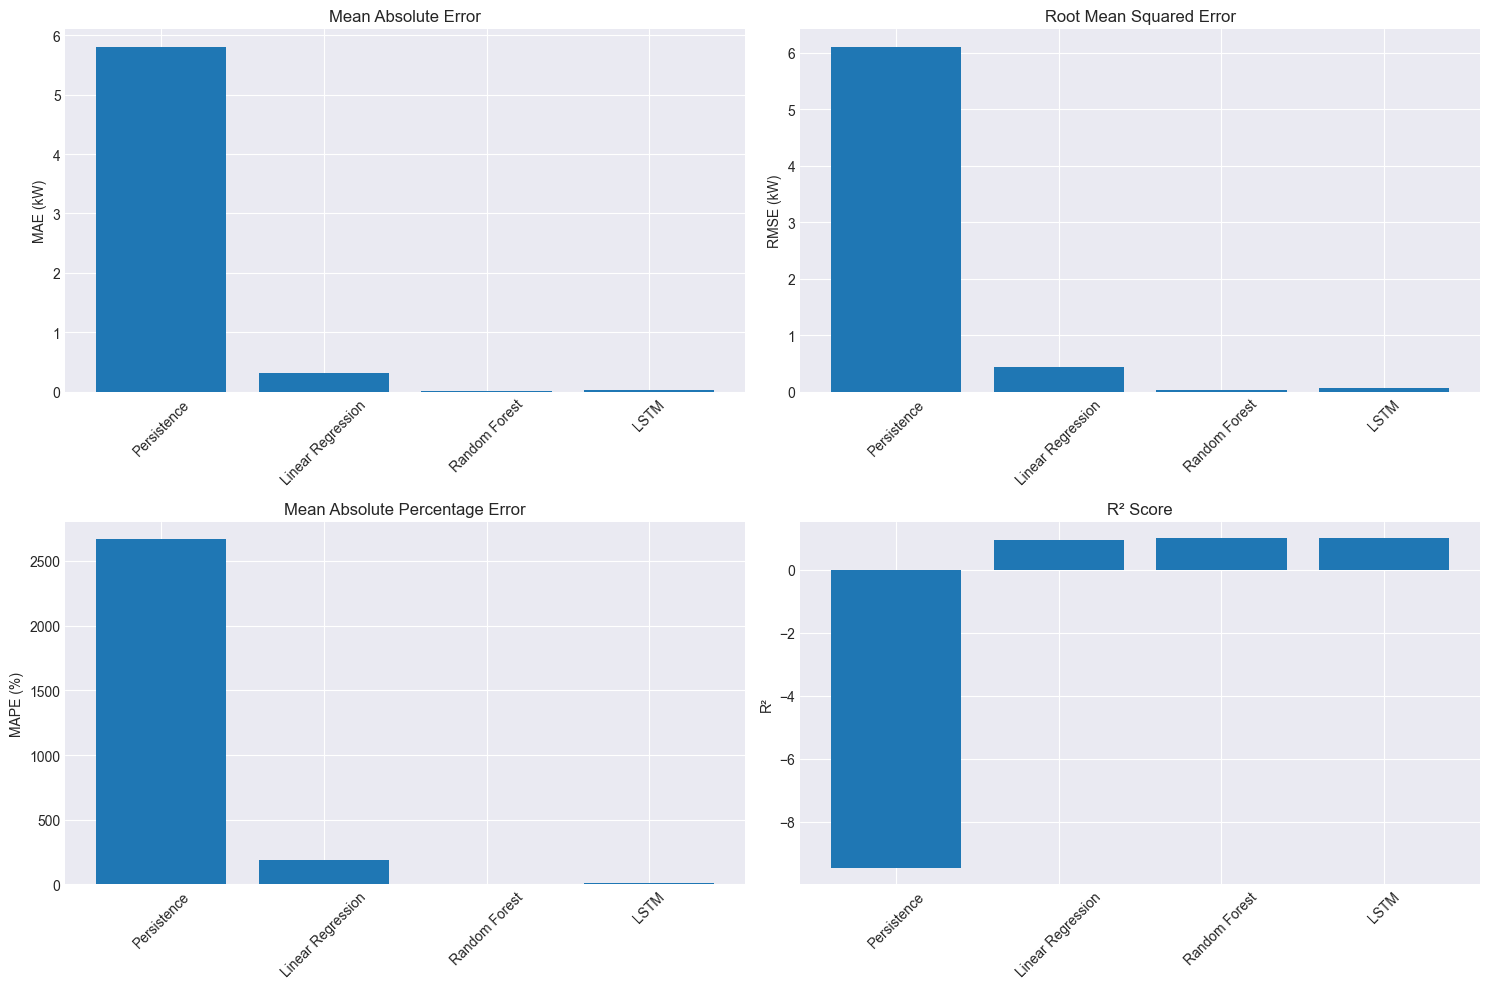

In [10]:
# Compare all models
results = {
    'Persistence': metrics_persistence,
    'Linear Regression': metrics_lr,
    'Random Forest': metrics_rf,
    'LSTM': metrics_lstm
}

results_df = pd.DataFrame(results).T
print("\nAll Baseline Models - Test Set Metrics:")
print(results_df.round(4))

# Save results
results_path = project_root / 'results' / 'metrics' / 'baseline_results.csv'
results_df.to_csv(results_path)
print(f"\n✅ Results saved to: {results_path}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MAE comparison
axes[0, 0].bar(results_df.index, results_df['MAE'])
axes[0, 0].set_ylabel('MAE (kW)')
axes[0, 0].set_title('Mean Absolute Error')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0, 1].bar(results_df.index, results_df['RMSE'])
axes[0, 1].set_ylabel('RMSE (kW)')
axes[0, 1].set_title('Root Mean Squared Error')
axes[0, 1].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[1, 0].bar(results_df.index, results_df['MAPE'])
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].set_title('Mean Absolute Percentage Error')
axes[1, 0].tick_params(axis='x', rotation=45)

# R² comparison
axes[1, 1].bar(results_df.index, results_df['R2'])
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
figures_dir = project_root / 'results' / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'baseline_comparison.png', dpi=150)
plt.show()
